# Protein Residue–Residue Contact Prediction and Classification

## Setup

In [1]:
from typing import SupportsAbs
from google.colab import drive
import json
import sys
import torch

drive.mount('/content/drive')

# Directories
PROJECT_DIR = "/content/drive/MyDrive/rcp"
SRC_DIR = f"{PROJECT_DIR}/src"
DATA_DIR = f"{PROJECT_DIR}/data"
MODEL_DIR = f"{PROJECT_DIR}/model"
SUPPLEMENTARY_DIR = f"{PROJECT_DIR}/supplementary"

# Files
DATA_FILE = f"{DATA_DIR}/data.csv"
with open(f"{MODEL_DIR}/config.json") as f:
    CONFIG_FILE = json.load(f)

# Add src directory to Python path
sys.path.append(SRC_DIR)

# Choose device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Mounted at /content/drive
Device: cuda


In [3]:
# --- Parameters ---
# Preprocessing
N_CLASSES = CONFIG_FILE["n_classes"]
LABELS_MAP = CONFIG_FILE["labels_map"]
SPLIT = CONFIG_FILE["split"]
SAMPLING_STRATEGY = {int(k): CONFIG_FILE["sampling_strategy"][k] for k in CONFIG_FILE["sampling_strategy"]}
FEATURES = CONFIG_FILE["features"]

### Libraries

In [2]:
!pip install py-ubjson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for py-ubjson: filename=py_ubjson-0.16.1-cp311-cp311-linux_x86_64.whl size=128159 sha256=8a319124f2fd229bb899ca1c6ad0f66c598d4933e33d32ad52d02cc4e344a601
  Stored in directory: /root/.cache/pip/wheels/ea/6d/84/2e549e1b2579fafeab6aa931f7ea74c6a72793ae4ecdea38db
Successfully built py-ubjson


In [4]:
# Python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ubjson
import xgboost as xgb

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import average_precision_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import train_test_split

In [5]:
# Custom
import utils

## Data

### Preprocess Data

#### Import

In [7]:
df = pd.read_csv(DATA_FILE)
df.head()

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,...,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,t_3di_letter,Interaction
0,1aba,A,23,,L,H,0.226,-1.127,-0.746,-1.019,...,-1.429,0.072,1.831,-0.561,0.533,-0.277,1.648,17.0,R,HBOND
1,1aba,A,23,,L,H,0.226,-1.127,-0.746,-1.019,...,-1.429,0.072,1.831,-0.561,0.533,-0.277,1.648,17.0,R,VDW
2,1aba,A,15,,G,H,0.369,-0.973,-0.856,-0.384,...,-1.079,-0.687,0.945,0.828,1.299,-0.169,0.933,9.0,J,HBOND
3,1aba,A,67,,Q,E,0.076,-2.214,2.152,0.931,...,-1.350,2.242,0.336,-0.417,-1.673,-1.474,-0.078,16.0,Q,HBOND
4,1aba,A,17,,C,H,0.000,-1.093,-0.837,-1.343,...,-1.058,-0.827,-0.591,-1.302,-0.733,1.570,-0.146,13.0,N,VDW


In [8]:
class_counts = df['Interaction'].value_counts()
print("--- Class counts (no NA's) ---")
print(class_counts)

--- Class counts (no NA's) ---
Interaction
Unclassified    1061992
HBOND           1027525
VDW              716942
PIPISTACK         37344
IONIC             34306
PICATION           8576
SSBOND             2018
PIHBOND            1724
Name: count, dtype: int64


#### Features

In [9]:
# Extract features
label_column = 'Interaction'
id_columns = ['pdb_id', 's_ch', 's_resi', 's_ins', 's_resn', 't_ch', 't_resi', 't_ins', 't_resn']
categorical_columns = ['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter']
numerical_columns = [col for col in df.columns if col not in id_columns + categorical_columns + [label_column]]

X = df.drop(columns=id_columns)

In [ ]:
# Visualize feature distribution
for feature in numerical_columns:
    plt.figure(figsize=(8, 3))
    sns.histplot(data=X, x=feature, hue='Interaction', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f"Distribution of {feature} by Interaction Type")
    plt.show()

In [11]:
# Remove label
X = X.drop(columns=[label_column])

#### Labels

In [12]:
y = df[label_column].map(LABELS_MAP).fillna(df[label_column])
y = np.array(y)

#### Train-test split

In [13]:
# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT['test'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=SPLIT['validation'], random_state=42)

#### Resampling

In [14]:
class_counts_train = pd.Series(y_train).value_counts()
print("--- Class counts in training set ---")
print(class_counts_train)
print("\n")
print("--- Sampling strategy ---")
print(SAMPLING_STRATEGY)

--- Class counts in training set ---
0    764634
1    739818
2    516198
3     26888
4     24700
5      6174
6      1453
7      1242
Name: count, dtype: int64


--- Sampling strategy ---
{0: 100000, 1: 100000, 2: 100000, 3: 30000, 4: 30000, 5: 30000, 6: 30000, 7: 30000}


In [15]:
# Undersampling
undersample_strategy = {
    cls: target for cls, target in SAMPLING_STRATEGY.items()
    if target < class_counts_train[cls]
}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [16]:
# Oversampling
current_counts = Counter(y_under)
oversample_strategy = {
    cls: target for cls, target in SAMPLING_STRATEGY.items()
    if target > current_counts[cls]
}

ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_under, y_under)

In [17]:
print("--- Class counts after resampling ---")
class_counts_resampled = pd.Series(y_train_resampled).value_counts()
print(class_counts_resampled)

--- Class counts after resampling ---
0    100000
1    100000
2    100000
3     30000
4     30000
5     30000
6     30000
7     30000
Name: count, dtype: int64


In [24]:
# --- Save datasets ---
# Resampled train set
X_train_resampled.to_parquet(f"{DATA_DIR}/train-resampled/X_train_resampled.parquet", compression='snappy')
np.save(f"{DATA_DIR}/train-resampled/y_train_resampled.npy", y_train_resampled)

# Validation
X_val.to_parquet(f"{DATA_DIR}/val/X_val.parquet", compression='snappy')
np.save(f"{DATA_DIR}/val/y_val.npy", y_val)

# Test
X_test.to_parquet(f"{DATA_DIR}/test/X_test.parquet", compression='snappy')
np.save(f"{DATA_DIR}/test/y_test.npy", y_test)

## Model: XGBoost

### Data

In [28]:
# --- Load data ---
# Train
X_train_resampled = pd.read_parquet(f"{DATA_DIR}/train-resampled/X_train_resampled.parquet")
y_train_resampled = np.load(f"{DATA_DIR}/train-resampled/y_train_resampled.npy")

# Validation
X_val = pd.read_parquet(f"{DATA_DIR}/val/X_val.parquet")
y_val = np.load(f"{DATA_DIR}/val/y_val.npy")

# Test
X_test = pd.read_parquet(f"{DATA_DIR}/test/X_test.parquet")
y_test = np.load(f"{DATA_DIR}/test/y_test.npy")

In [18]:
# Encode to categorical
categorical_columns = ['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter']

for col in categorical_columns:
    X_train_resampled[col] = X_train_resampled[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [19]:
# Use numerical and cateogrical features
train_data = xgb.DMatrix(X_train_resampled, label=y_train_resampled, enable_categorical=True)
test_data = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
val_data = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

### Parameters

In [20]:
with open(f"{SUPPLEMENTARY_DIR}/xgboost/config.json") as f:
    xgboost_config = json.load(f)

In [21]:
model_name = xgboost_config['model_name']
xgboost_params = xgboost_config['model_parameters']
es = xgboost_config['early_stopping']
verb = xgboost_config['verbose']

### Training

In [22]:
print(f"--- Training model {model_name} ---")
xgboost_model = xgb.train(xgboost_params,
                  train_data,
                  num_boost_round=2000,
                  evals=[(train_data, 'train'),(val_data, 'val')],
                  early_stopping_rounds=es,
                  verbose_eval=verb,
                  evals_result={})

--- Training model xgboost ---
[0]	train-mlogloss:1.79177	val-mlogloss:1.90150
[50]	train-mlogloss:0.75222	val-mlogloss:1.14841
[100]	train-mlogloss:0.62489	val-mlogloss:1.13638
[121]	train-mlogloss:0.58549	val-mlogloss:1.13650


In [60]:
# Save model
filename_xgboost_model = f"{SUPPLEMENTARY_DIR}/xgboost/{model_name}.ubj"
xgboost_model.save_model(filename_xgboost_model)

### Evaluation

In [23]:
# Load empty results file
with open(f"{SUPPLEMENTARY_DIR}/xgboost/results_init.json") as f:
    xgboost_results = json.load(f)

In [24]:
# Predict test data
y_pred_prob = xgboost_model.predict(test_data)
y_pred_labs = np.argmax(y_pred_prob, axis=1)

In [25]:
# Calculate accuracy scores
xgboost_results['results']['Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_labs, adjusted=True)
xgboost_results['results']['AUC-ROC'] = roc_auc_score(y_test, y_pred_prob, average='macro', multi_class='ovo')
xgboost_results['results']['Matthews Correlation Coefficient'] = matthews_corrcoef(y_test, y_pred_labs)
xgboost_results['results']['Average Precision Score'] = average_precision_score(y_test, y_pred_prob, average='macro')

In [26]:
# Print results
print(f"--- Results for model {xgboost_results['model_name']}---")
for metric, value in xgboost_results['results'].items():
    print(f'{metric}: {value:.3f}')

--- Results for model xgboost---
Balanced Accuracy: 0.605
AUC-ROC: 0.919
Matthews Correlation Coefficient: 0.219
Average Precision Score: 0.336


In [29]:
# Confusion matrix
xgboost_cm = confusion_matrix(y_test, y_pred_labs)
sorted_labels = sorted(LABELS_MAP.keys(), key=lambda x: LABELS_MAP[x])
xgboost_cm_df = pd.DataFrame(xgboost_cm, index=sorted_labels, columns=sorted_labels)
xgboost_results['confusion_matrix'] = xgboost_cm_df

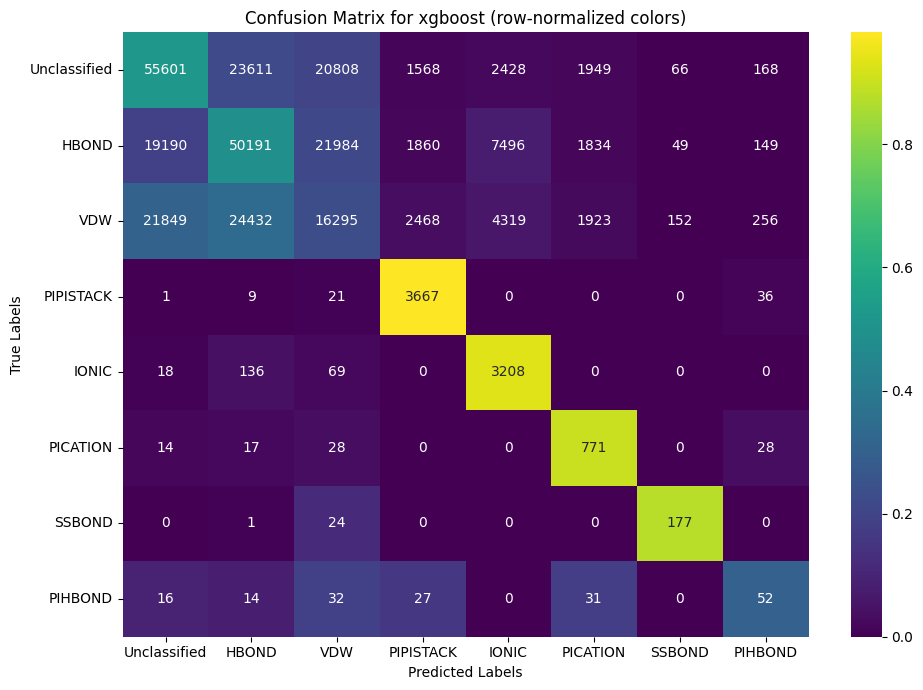

In [30]:
utils.plot_confusion_matrix(xgboost_cm, xgboost_cm_df.columns, model_name=model_name)

In [72]:
# Save results
filename_xgboost_results = f"{SUPPLEMENTARY_DIR}/{model_name}/results.json"
xgboost_results['confusion_matrix'] = xgboost_results['confusion_matrix'].to_dict(orient='records')
with open(filename_xgboost_results, 'w') as file:
    json.dump(xgboost_results, file, indent=4)

## Model: XGBoost OvR Ensemble

### Data

In [31]:
# --- Load data ---
# Train
X_train_resampled = pd.read_parquet(f"{DATA_DIR}/train-resampled/X_train_resampled.parquet")
y_train_resampled = np.load(f"{DATA_DIR}/train-resampled/y_train_resampled.npy")

# Validation
X_val = pd.read_parquet(f"{DATA_DIR}/val/X_val.parquet")
y_val = np.load(f"{DATA_DIR}/val/y_val.npy")

# Test
X_test = pd.read_parquet(f"{DATA_DIR}/test/X_test.parquet")
y_test = np.load(f"{DATA_DIR}/test/y_test.npy")

In [32]:
# Encode to categorical
categorical_columns = ['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter']

for col in categorical_columns:
    X_train_resampled[col] = X_train_resampled[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_val[col] = X_val[col].astype('category')

### Parameters

In [33]:
# Model-specific
MODEL_NAME = CONFIG_FILE["model_name"]
MODEL_PARAMETERS = CONFIG_FILE["model_parameters"]
EARLY_STOPPING = CONFIG_FILE["early_stopping"]
VERBOSE = CONFIG_FILE["verbose"]

### Training

In [34]:
# Train
xgboost_ovr_models = utils.train_ovr_ensemble(MODEL_NAME, X_train_resampled, y_train_resampled, X_val, y_val, MODEL_PARAMETERS)

--- Training model xgboost-ovr-ensemble for class 0 ---
[0]	train-logloss:0.50206	val-logloss:0.66979
[50]	train-logloss:0.34511	val-logloss:0.61275
[88]	train-logloss:0.30536	val-logloss:0.61199
--- Training model xgboost-ovr-ensemble for class 1 ---
[0]	train-logloss:0.50630	val-logloss:0.66259
[50]	train-logloss:0.37271	val-logloss:0.62255
[69]	train-logloss:0.35236	val-logloss:0.62265
--- Training model xgboost-ovr-ensemble for class 2 ---
[0]	train-logloss:0.51481	val-logloss:0.56071
[15]	train-logloss:0.45257	val-logloss:0.58142
--- Training model xgboost-ovr-ensemble for class 3 ---
[0]	train-logloss:0.20918	val-logloss:0.14943
[39]	train-logloss:0.04266	val-logloss:0.03505
--- Training model xgboost-ovr-ensemble for class 4 ---
[0]	train-logloss:0.21597	val-logloss:0.15516
[48]	train-logloss:0.05870	val-logloss:0.06006
--- Training model xgboost-ovr-ensemble for class 5 ---
[0]	train-logloss:0.20862	val-logloss:0.13944
[50]	train-logloss:0.03559	val-logloss:0.02821
[100]	train-

In [31]:
# Save ensemble models
ENSEMBLE_DIR = f"{MODEL_DIR}/trained-ensemble"
utils.save_ovr_models(xgboost_ovr_models, MODEL_NAME, ENSEMBLE_DIR)

Saved model for class 0 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_0.ubj
Saved model for class 1 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_1.ubj
Saved model for class 2 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_2.ubj
Saved model for class 3 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_3.ubj
Saved model for class 4 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_4.ubj
Saved model for class 5 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_5.ubj
Saved model for class 6 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_6.ubj
Saved model for class 7 → /content/drive/MyDrive/rcp/model/trained-ensemble/xgboost-ovr-ensemble_class_7.ubj


### Evaluation

In [35]:
# Load empty results file
with open(f"{MODEL_DIR}/results_init.json") as f:
    xgboost_ovr_results = json.load(f)

In [38]:
# Load model
ENSEMBLE_DIR = f"{MODEL_DIR}/trained-ensemble"
xgboost_ovr_models = utils.load_ovr_models(MODEL_NAME, ENSEMBLE_DIR, MODEL_PARAMETERS)

In [39]:
# Predict test data
y_pred_labs, y_pred_prob = utils.predict_ovr(xgboost_ovr_models, X_test)
y_pred_prob_norm = y_pred_prob / y_pred_prob.sum(axis=1, keepdims=True)

In [40]:
xgboost_ovr_results['results']['Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_labs, adjusted=True)
xgboost_ovr_results['results']['AUC-ROC'] = roc_auc_score(y_test, y_pred_prob_norm, average='macro', multi_class='ovo')
xgboost_ovr_results['results']['Matthews Correlation Coefficient'] = matthews_corrcoef(y_test, y_pred_labs)
xgboost_ovr_results['results']['Average Precision Score'] = average_precision_score(y_test, y_pred_prob_norm, average='macro')

In [41]:
# Print results
print(f"--- Results for model {xgboost_ovr_results['model_name']}---")
for metric, value in xgboost_ovr_results['results'].items():
    print(f'{metric}: {value:.3f}')

--- Results for model xgboost-ovr-ensemble---
Balanced Accuracy: 0.622
AUC-ROC: 0.923
Matthews Correlation Coefficient: 0.231
Average Precision Score: 0.355


In [42]:
# Confusion matrix
xgboost_ovr_cm = confusion_matrix(y_test, y_pred_labs)
sorted_labels = sorted(LABELS_MAP.keys(), key=lambda x: LABELS_MAP[x])
xgboost_ovr_cm_df = pd.DataFrame(xgboost_ovr_cm, index=sorted_labels, columns=sorted_labels)
xgboost_ovr_results['confusion_matrix'] = xgboost_ovr_cm_df

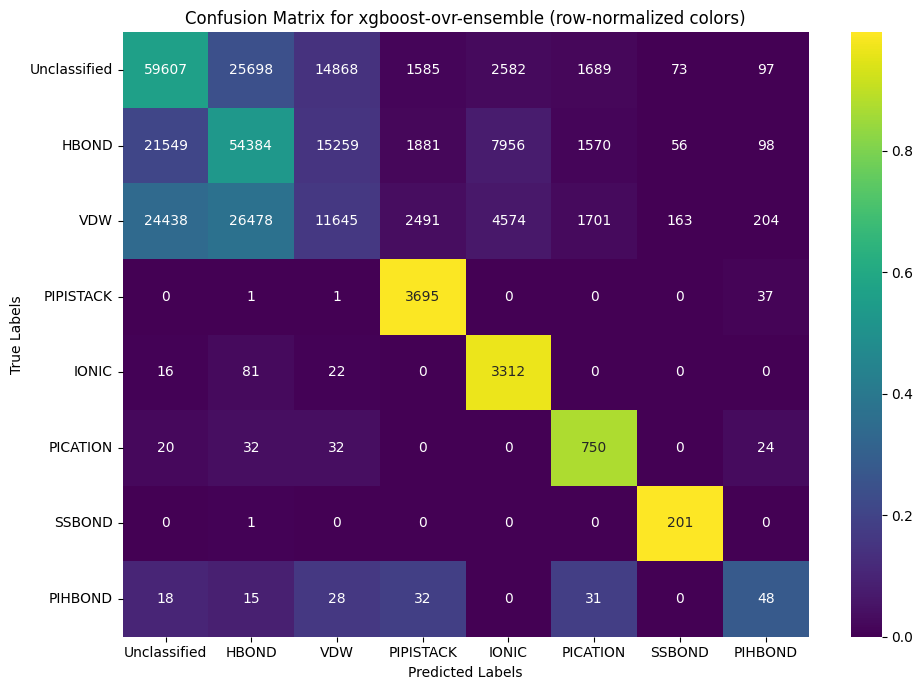

In [43]:
utils.plot_confusion_matrix(xgboost_ovr_cm, xgboost_ovr_cm_df.columns, MODEL_NAME)

In [42]:
# Save model results
filename_xgboost_ovr_results = f"{MODEL_DIR}/results.json"
xgboost_ovr_results['confusion_matrix'] = xgboost_ovr_results['confusion_matrix'].to_dict(orient='records')
with open(filename_xgboost_ovr_results, 'w') as file:
    json.dump(xgboost_ovr_results, file, indent=4)